# `sum`: Recalling the first lecture: an easy enough function to understand

The  **sum** function `sum(a)`, which computes

$$
\mathrm{sum}(a) = \sum_{i=1}^n a_i.
$$

In [6]:
Pkg.add("BenchmarkTools")
using BenchmarkTools

INFO: Nothing to be done
INFO: METADATA is out-of-date — you may not have the latest version of BenchmarkTools
INFO: Use `Pkg.update()` to get the latest versions of your packages


# 1. serial Julia (as fast as handwritten c)

In [2]:
function jsum(A)   
    s = 0.0  # s = zero(eltype(A))
    for a in A
        s += a
    end
    s
end

jsum (generic function with 1 method)

In [3]:
a = rand(10^7) # array of random numbers, uniform on [0,1)
j_bench = @benchmark jsum($a)
minimum(j_bench.times)/1e6

8.139245

# 2a. Distributed Computing with DArrays (my favorite for the high level -- I wish it were more complete)

In [4]:
Pkg.add("DistributedArrays")
using DistributedArrays

INFO: Nothing to be done
INFO: METADATA is out-of-date — you may not have the latest version of DistributedArrays
INFO: Use `Pkg.update()` to get the latest versions of your packages


In [5]:
A = distribute(a)  # one could have used A = drand(10^7) for a parallel constructor
A.indexes

1-element Array{Tuple{UnitRange{Int64}},1}:
 (1:10000000,)

In [6]:
addprocs(2)

2-element Array{Int64,1}:
 2
 3

In [9]:
@everywhere using DistributedArrays
A = distribute(a)
A.indexes

2-element Array{Tuple{UnitRange{Int64}},1}:
 (1:5000000,)       
 (5000001:10000000,)

In [10]:
sum(A)-sum(a)

0.0

In [11]:
minimum((@benchmark sum($A)).times)/1e6

2.60258

In [12]:
addprocs(1)

1-element Array{Int64,1}:
 4

In [13]:
workers()

3-element Array{Int64,1}:
 2
 3
 4

In [14]:
@everywhere using DistributedArrays

In [15]:
A = distribute(a)  # one could have used A = drand(10^7) for a parallel constructor
sum(A) - sum(a)

0.0

In [16]:
A.indexes

3-element Array{Tuple{UnitRange{Int64}},1}:
 (1:3333333,)       
 (3333334:6666667,) 
 (6666668:10000000,)

In [17]:
minimum((@benchmark sum($A)).times)/1e6

2.241721

In [21]:
#addprocs(1)
workers()

4-element Array{Int64,1}:
 2
 3
 4
 5

In [22]:
@everywhere using DistributedArrays

In [23]:
A = distribute(a)  # one could have used A = drand(10^7) for a parallel constructor
sum(A) - sum(a)

0.0

In [24]:
minimum((@benchmark sum($A)).times)/1e6

2.079622

In [38]:
@everywhere using DistributedArrays

In [39]:
A = distribute(a)  # one could have used A = drand(10^7) for a parallel constructor
sum(A) - sum(a)

0.0

In [40]:
minimum((@benchmark sum($A)).times)/1e6

4.166501

In [37]:
summary(A)

"10000000-element DistributedArrays.DArray{Float64,1,Array{Float64,1}}"

In [41]:
@which sum(A)

sum(d::DistributedArrays.DArray) at /Users/edelman/.julia/v0.5/DistributedArrays/src/mapreduce.jl:127

In [42]:
@which reduce(+,A)

reduce(f, d::DistributedArrays.DArray) at /Users/edelman/.julia/v0.5/DistributedArrays/src/mapreduce.jl:9

## 2b. How do we implement DArray functionality?  Answer: Bootstrap from serial functionality.

In [25]:
#@everywhere using DistributedArrays
A = drand(10^7)

10000000-element DistributedArrays.DArray{Float64,1,Array{Float64,1}}:
 0.844815 
 0.0706291
 0.244676 
 0.257673 
 0.850414 
 0.738974 
 0.594129 
 0.585809 
 0.245183 
 0.249112 
 0.0265877
 0.180143 
 0.355788 
 ⋮        
 0.119152 
 0.687844 
 0.987118 
 0.0716491
 0.150896 
 0.29818  
 0.515473 
 0.661692 
 0.795226 
 0.931143 
 0.452085 
 0.175229 

In [5]:
a = convert( Array{Float64,1} , A)

10000000-element Array{Float64,1}:
 0.404224  
 0.697706  
 0.376151  
 0.238845  
 0.0161963 
 0.187521  
 0.951739  
 0.569651  
 0.607052  
 0.750241  
 0.00569606
 0.694259  
 0.213993  
 ⋮         
 0.64419   
 0.0347608 
 0.868681  
 0.360796  
 0.589133  
 0.00117402
 0.469419  
 0.933901  
 0.0584435 
 0.0569092 
 0.32551   
 0.67888   

In [6]:
# Simulated Parallel Algorithm
s = sum.([a[i[1]] for i in A.indexes]) 
display(s)
sum(s)

4-element Array{Float64,1}:
 1.25067e6
 1.2508e6 
 1.24895e6
 1.25045e6

5.000864179629135e6

In [33]:
# Actual Parallel Algorithm

In [26]:
for p in A.pids
    display(fetch(@spawnat p sum(localpart(A))))
end

1.250667157248437e6

1.2507993276603317e6

1.2489514266074374e6

1.2504462681129284e6

In [24]:
results = Float64[]
for p in A.pids
    results = push!(results, fetch(@spawnat p sum(localpart(A))))
end
sum(results)

5.000864179629135e6

In [25]:
sum(a)

5.000864179629135e6

In [27]:
std(A)

0.288655919036807

In [28]:
mean(A)

0.5000864179629134

In [29]:
# What about a histogram?

In [35]:
Pkg.add("StatsBase")
using StatsBase

INFO: Nothing to be done
INFO: METADATA is out-of-date — you may not have the latest version of StatsBase
INFO: Use `Pkg.update()` to get the latest versions of your packages


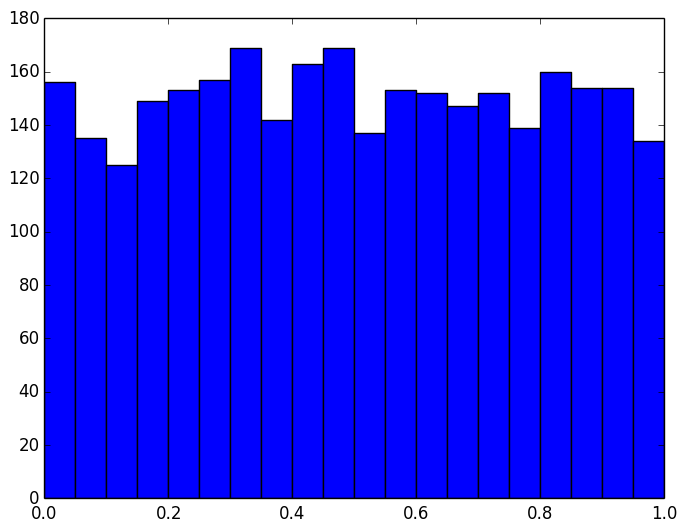

(PyObject <matplotlib.patches.Rectangle object at 0x328253050>,PyObject <matplotlib.patches.Rectangle object at 0x328253690>,PyObject <matplotlib.patches.Rectangle object at 0x328253d10>,PyObject <matplotlib.patches.Rectangle object at 0x3282603d0>,PyObject <matplotlib.patches.Rectangle object at 0x328260a50>,PyObject <matplotlib.patches.Rectangle object at 0x328260f50>,PyObject <matplotlib.patches.Rectangle object at 0x32826c790>,PyObject <matplotlib.patches.Rectangle object at 0x32826ce10>,PyObject <matplotlib.patches.Rectangle object at 0x3282784d0>,PyObject <matplotlib.patches.Rectangle object at 0x328278b50>,PyObject <matplotlib.patches.Rectangle object at 0x328286210>,PyObject <matplotlib.patches.Rectangle object at 0x328286890>,PyObject <matplotlib.patches.Rectangle object at 0x328286f10>,PyObject <matplotlib.patches.Rectangle object at 0x3282915d0>,PyObject <matplotlib.patches.Rectangle object at 0x328291c50>,PyObject <matplotlib.patches.Rectangle object at 0x32829e310>,PyObjec

In [67]:
w = fit(Histogram, rand(3000), 0:0.05:1.0).weights
bar(0:.05:.95,w,.05)

In [49]:
using PyPlot

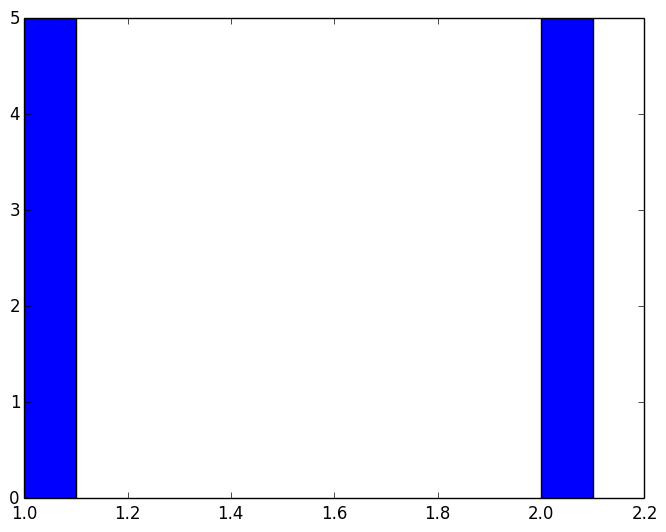

(PyObject <matplotlib.patches.Rectangle object at 0x32794fc10>,PyObject <matplotlib.patches.Rectangle object at 0x32795b290>)

In [75]:
A = drand(10^8)
@everywhere using StatsBase
@everywhere w1(x) = fit(Histogram,x,0:0.05:1.0).weights
results = Array{Int64,1}[]
for p in A.pids
    results = push!(results, fetch(@spawnat p w1(localpart(A))))
end
sum(results)

20-element Array{Int64,1}:
 4999961
 4999755
 5000471
 4998540
 5000051
 4998667
 4999459
 4999721
 4996973
 4999831
 5002576
 5001157
 5001331
 4999327
 4999012
 4999832
 5003440
 5001896
 4998734
 4999266

In [69]:
nprocs()

5

## 3. @parallel  (looks like a "for loop", data starts and ends on master)

The history of Julia includes a "back and forth" between "for loop" notation and vectorized
notation.  The truth is, for some problems, one or the other, or both could be more natural,
or more performant, but not for the old reasons of dynamic languages where "for loops" were
always to be avoided.

In [26]:
@parallel (+) for aa in a
    aa # this could be a more complicated statistic
end

5.00118921878265e6

In [27]:
@benchmark @parallel (+) for aa in a
    aa 
end

BenchmarkTools.Trial: 
  memory estimate:  46.38 kb
  allocs estimate:  483
  --------------
  minimum time:     98.556 ms (0.00% GC)
  median time:      102.925 ms (0.00% GC)
  mean time:        103.572 ms (0.00% GC)
  maximum time:     111.383 ms (0.00% GC)
  --------------
  samples:          49
  evals/sample:     1
  time tolerance:   5.00%
  memory tolerance: 1.00%

In [28]:
@everywhere randstat(n) = maximum(eigvals(SymTridiagonal(randn(n),randn(n-1))))

In [87]:
workers()

3-element Array{Int64,1}:
 2
 3
 4

In [29]:
@benchmark @parallel (+) for i in 1:250
    randstat(500) 
end

BenchmarkTools.Trial: 
  memory estimate:  45.47 kb
  allocs estimate:  580
  --------------
  minimum time:     414.461 ms (0.00% GC)
  median time:      416.580 ms (0.00% GC)
  mean time:        417.545 ms (0.00% GC)
  maximum time:     424.996 ms (0.00% GC)
  --------------
  samples:          12
  evals/sample:     1
  time tolerance:   5.00%
  memory tolerance: 1.00%

In [30]:
@benchmark mapreduce(randstat,+,500*dones(Int,250))

BenchmarkTools.Trial: 
  memory estimate:  166.86 kb
  allocs estimate:  2491
  --------------
  minimum time:     414.413 ms (0.00% GC)
  median time:      417.328 ms (0.00% GC)
  mean time:        419.344 ms (0.00% GC)
  maximum time:     430.229 ms (0.00% GC)
  --------------
  samples:          12
  evals/sample:     1
  time tolerance:   5.00%
  memory tolerance: 1.00%

## 4. MPI is possible for the die-hards and also some libraries

In [31]:
Pkg.build("MPI")

INFO: Building MPI
INFO: Attempting to Create directory /Users/alanedelman/.julia/v0.5/MPI/deps/build
INFO: Changing Directory to /Users/alanedelman/.julia/v0.5/MPI/deps/build


-- The Fortran compiler identification is GNU 5.2.0
-- The C compiler identification is AppleClang 8.0.0.8000042
-- Checking whether Fortran compiler has -isysroot
-- Checking whether Fortran compiler has -isysroot - yes
-- Checking whether Fortran compiler supports OSX deployment target flag
-- Checking whether Fortran compiler supports OSX deployment target flag - yes
-- Check for working Fortran compiler: /usr/local/bin/gfortran
-- Check for working Fortran compiler: /usr/local/bin/gfortran  -- works
-- Detecting Fortran compiler ABI info
-- Detecting Fortran compiler ABI info - done
-- Checking whether /usr/local/bin/gfortran supports Fortran 90
-- Checking whether /usr/local/bin/gfortran supports Fortran 90 -- yes
-- Check for working C compiler: /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/cc
-- Check for working C compiler: /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/cc -- works
-- Detecting C c

In [32]:
using MPI

INFO: Recompiling stale cache file /Users/alanedelman/.julia/lib/v0.5/MPI.ji for module MPI.


In [33]:
rmprocs(2:5) # just for good luck

:ok

In [34]:
m = MPIManager(np=4)
addprocs(m)


4-element Array{Int64,1}:
  7
  8
  9
 10

In [35]:
@mpi_do m comm = MPI.COMM_WORLD

In [42]:
function f(n)

 @mpi_do m begin
 comm = MPI.COMM_WORLD
 s = rand(Int($n/4))
 end
    
end

f (generic function with 1 method)

In [44]:
@fetchfrom 2 f(8)

LoadError: ProcessExitedException()

## 5. Threads are still mysterious to me

In [7]:
function sim(n, seed = rand(UInt))
    nt = Threads.nthreads()
    ra = zeros(nt)
    Threads.@threads for i in 1:nt
        id   = Threads.threadid()
        rng  = MersenneTwister(id + seed)
        d, r = divrem(n, Threads.nthreads())
        bs = d + (r > 0)
        if id == nt
            bs = n - (nt - 1)*bs
        end
        ra[id] = sum(rand(rng, bs))
    end
    return sum(ra)
end

sim (generic function with 2 methods)

In [12]:
@benchmark sim(10^7)

BenchmarkTools.Trial: 
  memory estimate:  76.30 mb
  allocs estimate:  14
  --------------
  minimum time:     30.899 ms (24.22% GC)
  median time:      31.950 ms (23.90% GC)
  mean time:        32.455 ms (24.68% GC)
  maximum time:     76.777 ms (68.97% GC)
  --------------
  samples:          155
  evals/sample:     1
  time tolerance:   5.00%
  memory tolerance: 1.00%

In [22]:
function sim2(a)
    nt = Threads.nthreads()
    return sum(a)
end

sim2 (generic function with 1 method)

In [23]:
a =  rand(10^7)
@benchmark sim2(a)

BenchmarkTools.Trial: 
  memory estimate:  16.00 bytes
  allocs estimate:  1
  --------------
  minimum time:     4.637 ms (0.00% GC)
  median time:      4.922 ms (0.00% GC)
  mean time:        5.010 ms (0.00% GC)
  maximum time:     6.658 ms (0.00% GC)
  --------------
  samples:          997
  evals/sample:     1
  time tolerance:   5.00%
  memory tolerance: 1.00%

In [19]:
workers()

1-element Array{Int64,1}:
 1

## 6.  GPU Libraries using ArrayFire

In [45]:
Pkg.add("ArrayFire")

INFO: Installing ArrayFire v0.0.3
INFO: Package database updated
INFO: METADATA is out-of-date — you may not have the latest version of ArrayFire
INFO: Use `Pkg.update()` to get the latest versions of your packages


In [1]:
using ArrayFire

In [2]:
a = rand(Float32,10^7); # My GPU doesn't support double precision

10000000-element Array{Float32,1}:
 0.602606 
 0.857504 
 0.368865 
 0.86829  
 0.6268   
 0.785859 
 0.249992 
 0.8439   
 0.91937  
 0.528383 
 0.435531 
 0.323874 
 0.330391 
 ⋮        
 0.566189 
 0.613945 
 0.387658 
 0.77906  
 0.204434 
 0.437771 
 0.738334 
 0.0846951
 0.0432457
 0.710364 
 0.306392 
 0.338133 

In [3]:
A = AFArray(a); summary(A)

"10000000-element ArrayFire.AFArray{Float32,1}"

In [7]:
@benchmark sum(a)

BenchmarkTools.Trial: 
  memory estimate:  16.00 bytes
  allocs estimate:  1
  --------------
  minimum time:     2.001 ms (0.00% GC)
  median time:      2.039 ms (0.00% GC)
  mean time:        2.086 ms (0.00% GC)
  maximum time:     3.142 ms (0.00% GC)
  --------------
  samples:          2396
  evals/sample:     1
  time tolerance:   5.00%
  memory tolerance: 1.00%

In [10]:
t =@benchmark  @sync sum($A);

In [59]:
sum(A) ≈ sum(a)

true

In [11]:
minimum(t.times)

2.763515e6

In [69]:
A = AFArray(rand(Float32,2));
println(summary(A))
typeof(sum(A))

2-element ArrayFire.AFArray{Float32,1}


Float64

In [68]:
typeof(sum(A))


Float64